## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Calibrate Camera

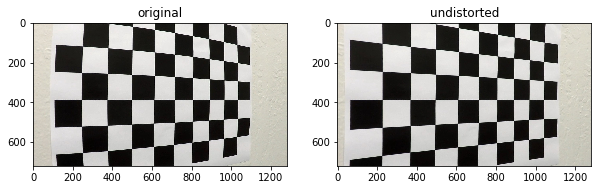

In [2]:
# Make a list of camera calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Initialize arrays of object points and image points
objpoints = []
imgpoints = []

# Prepare object points arrays that will be repeated for all images
board_shape = (9, 6)
objp = np.zeros((board_shape[0]*board_shape[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:board_shape[0], 0:board_shape[1]].T.reshape(-1, 2)

# Prepare a list of files with undetected corners for testing
undetected = []

# iterate through images
for fname in images:    
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find corners in image
    ret, corners = cv2.findChessboardCorners(gray, board_shape, None)
    
    # Add detected corners (and object points) to big lists
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    else:
        undetected.append(fname)
        
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

test_image = mpimg.imread(undetected[0])
undistorted = cv2.undistort(test_image, mtx, dist, None, mtx)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(test_image);
ax[1].imshow(undistorted);
ax[0].set_title('original')
ax[1].set_title('undistorted')
plt.savefig('./output_images/undistorted_checkerboard_{}'.format(undetected[0][-5]))

# Pipeline (single images)

## Distortion Correction
The following is just an example of a test road image before and after distortion correction

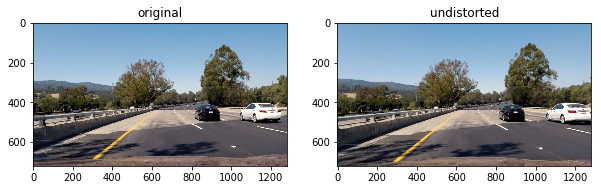

In [3]:
test_image = mpimg.imread('./test_images/test4.jpg')
undistorted = cv2.undistort(test_image, mtx, dist, None, mtx)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(test_image);
ax[1].imshow(undistorted);
ax[0].set_title('original')
ax[1].set_title('undistorted')
plt.savefig('./output_images/undistorted_test4')

## Color and Gradient Thresholding

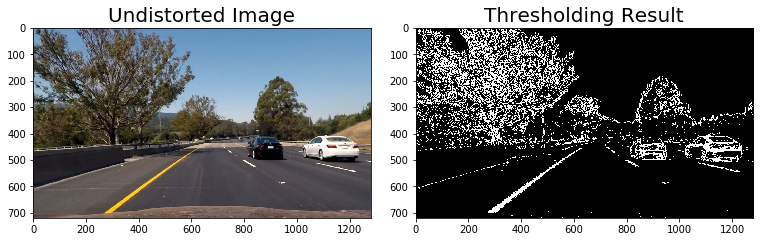

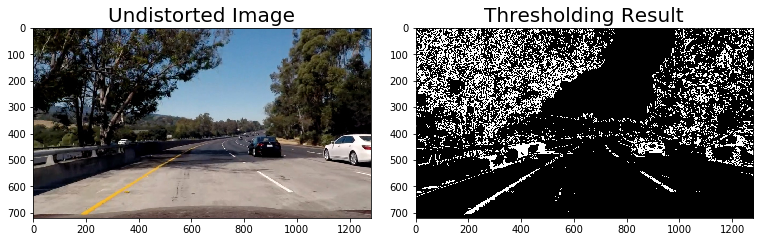

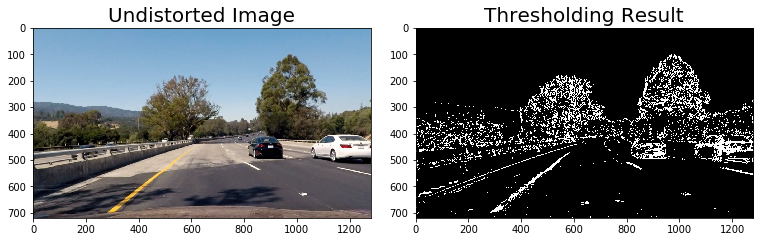

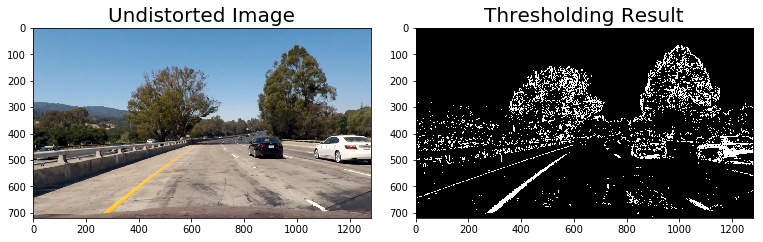

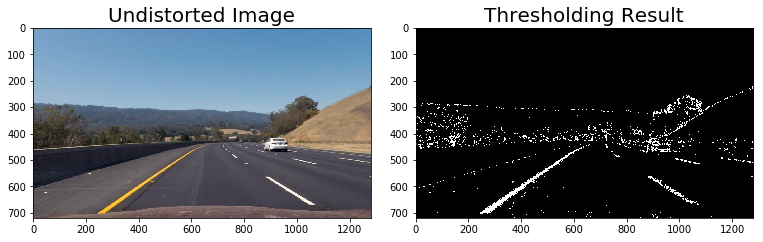

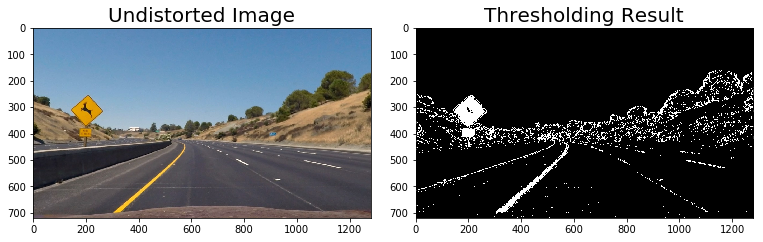

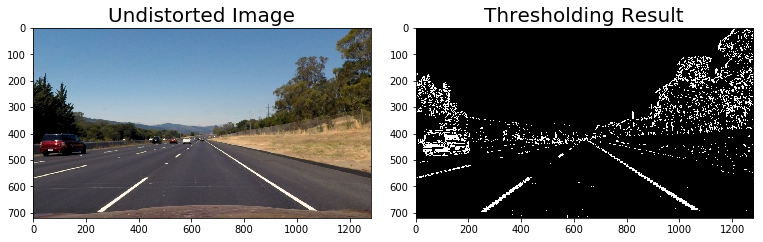

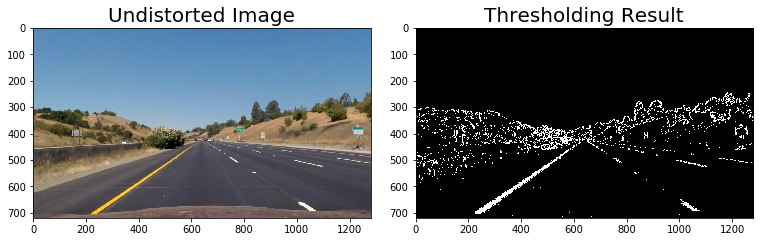

In [4]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Isolate the blue channel for sobel filtering, so the yellow line is easily detected
    b_channel = img[:,:,2]
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(b_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

images = glob.glob('./test_images/*.jpg');

for fname in images:    
    img = mpimg.imread(fname)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary = threshold(undistorted)
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(undistorted)
    ax1.set_title('Undistorted Image', fontsize=20)

    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Thresholding Result', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    plt.savefig('./output_images/thresholded_{}'.format(fname.split('/')[-1]))

## Perspective Warping

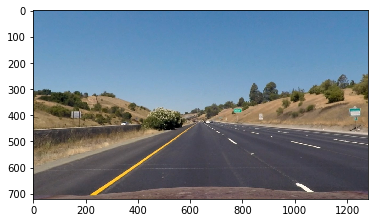

In [5]:
# This image is used for finding source coordinates for the perspective transform
straight_lines = './test_images/straight_lines1.jpg'
img = mpimg.imread(straight_lines)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, ax = plt.subplots(1,1)
plt.imshow(undistorted)

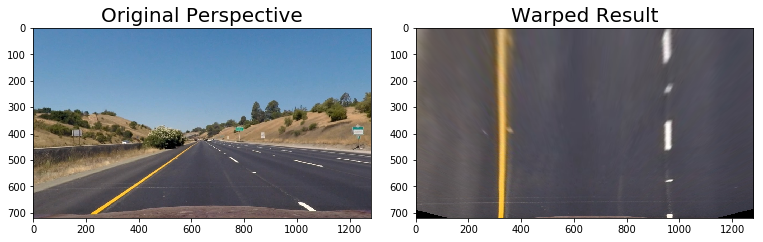

In [6]:
# I hand=measured the "source" points of a trapezoid here
# src = np.float32([[585,460],[203,720],[1127,720],[695,460]]) - example points
# Omit hood of car
src = np.float32([[581,460],[248,690],[1056,690],[703,460]])
#  The "destination" points were chosen to result in a perfect birds-eye view of th road
dst = np.float32([[320,0],[320,720],[960,720],[960,0]])

# Calculate the perspective transform to be used for all images
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undistorted, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Perspective', fontsize=20)

ax2.imshow(warped)
ax2.set_title('Warped Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/warped_perspective')

## Lane line polynomials

In [44]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def fit_lane_pixels_from_windows(binary_image, paired_centroids, window_width, window_height):
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_windows = int(binary_image.shape[0]/window_height)
    
    left_lane_inds = []
    right_lane_inds = []
    
    for ind in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_image.shape[0] - (ind+1)*window_height
        win_y_high = binary_image.shape[0] - ind*window_height
        win_xleft_low = paired_centroids[ind][0] - window_width
        win_xleft_high = paired_centroids[ind][0] + window_width
        win_xright_low = paired_centroids[ind][1] - window_width
        win_xright_high = paired_centroids[ind][1] + window_width
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
    # Concatenate all indices        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
        # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # From eyeballing pixels in between lanes
    ym = 28.5/720
    xm = 3.7/642
    
    left_fit_m = np.polyfit(lefty*ym, leftx*xm, 2)
    right_fit_m = np.polyfit(righty*ym, rightx*xm, 2)
    
    radius = radius_calc(left_fit_m, right_fit_m, ym, xm)
    offset = offset_calc(left_fit_m, right_fit_m, ym, xm)

    # Highlight lane pixels and draw fit polynomials
    lane_pixel_img = np.dstack((binary_image, binary_image, binary_image))*255
    lane_pixel_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lane_pixel_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    return left_fit, right_fit, radius, offset, lane_pixel_img

def draw_polynomial(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0]*y**2 + fit[1]*y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255, 255,0), thickness=5)


In [45]:
def radius_calc(left_fit, right_fit, ym, xm):
    left_curverad =  ((1 + (2*left_fit[0]*720*ym + left_fit[1])**2)**(3/2))/np.abs(2*left_fit[0])
    right_curverad =  ((1 + (2*right_fit[0]*720*ym + right_fit[1])**2)**(3/2))/np.abs(2*right_fit[0])
    return np.mean([left_curverad, right_curverad])

def offset_calc(left_fit, right_fit, ym, xm):
    left_lane = left_fit[0]*(720*ym)**2 + left_fit[1]*720*ym + left_fit[2]
    right_lane = right_fit[0]*(720*ym)**2 + right_fit[1]*720*ym + right_fit[2]
    return 640*xm - np.mean([left_lane, right_lane]), right_lane-left_lane

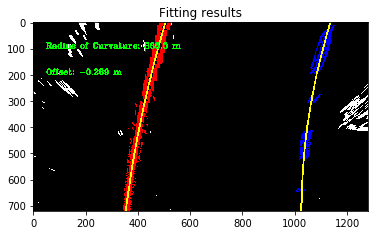

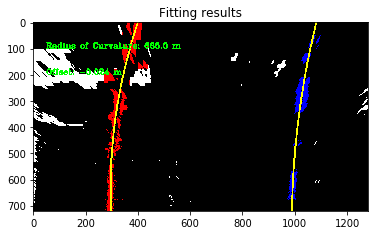

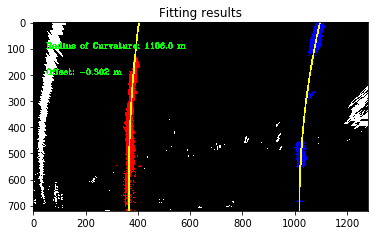

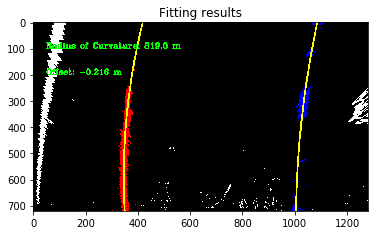

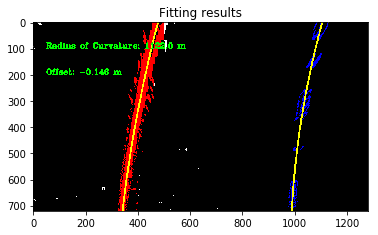

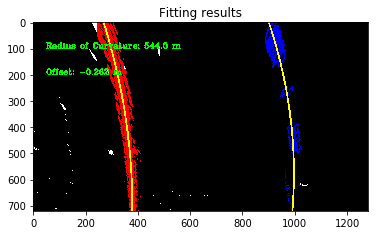

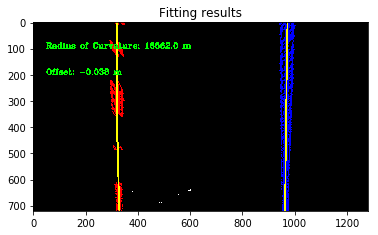

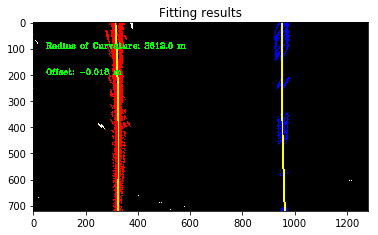

In [46]:
# window settings
window_width = 50
window_height = 180 # Break image into4 vertical layers, as that seemed to effectively gather up all lane line pixels
margin = 100 # How much to slide left and right for searching

for fname in images:

    img = mpimg.imread(fname)
    # Distort, threshold and warp
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded = threshold(undistorted)
    warped = cv2.warpPerspective(thresholded, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

#         # Points used to draw all the left and right windows
#         l_points = np.zeros_like(warped)
#         r_points = np.zeros_like(warped)

#         # Go through each level and draw the windows 	
#         for level in range(0,len(window_centroids)):
#             # Window_mask is a function to draw window areas
#             l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
#             r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
#             # Add graphic points from window mask here to total pixels found 
#             l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#             r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#         # Draw the results
#         template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#         zero_channel = np.zeros_like(template) # create a zero color channel
#         template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#         warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
#         output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # Print out detected pixels for left and right lanes
        left_fit, right_fit, radius, offset, lane_pixel_image = fit_lane_pixels_from_windows(warped, window_centroids, window_width, window_height)
        
        draw_polynomial(lane_pixel_image, left_fit)
        draw_polynomial(lane_pixel_image, right_fit)
        cv2.putText(lane_pixel_image, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 4)
        cv2.putText(lane_pixel_image, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 4)

        output = lane_pixel_image
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.figure()
    plt.imshow(output)
    plt.title('Fitting results')
    plt.show()
    plt.savefig('./output_images/fit_polynomials_{}'.format(fname.split('/')[-1]))


## Projection onto road

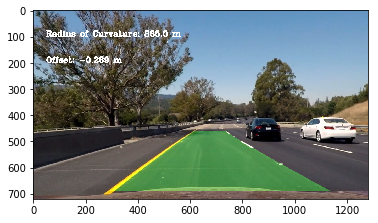

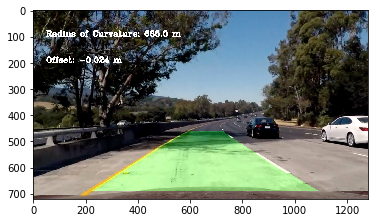

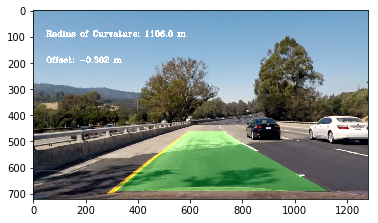

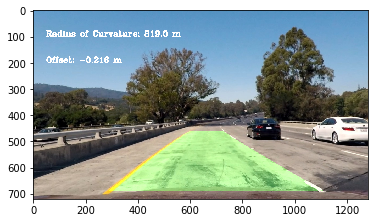

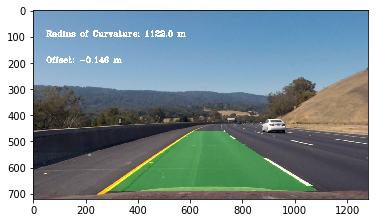

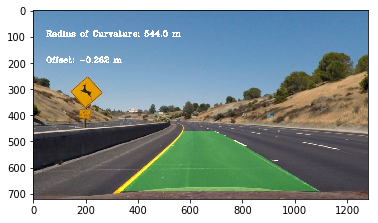

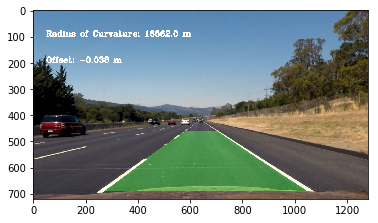

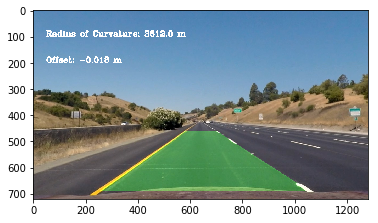

In [47]:
for fname in images:
    
    img = mpimg.imread(fname)
    # Distort, threshold and warp
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded = threshold(undistorted)
    warped = cv2.warpPerspective(thresholded, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # Print out detected pixels for left and right lanes
    left_fit, right_fit, radius, offset, lane_pixel_image = fit_lane_pixels_from_windows(warped, window_centroids, window_width, window_height)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    cv2.putText(result, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    plt.figure()
    plt.imshow(result)
    plt.savefig('./output_images/projection_{}'.format(fname.split('/')[-1]))


## Video Generation

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [14]:
def process_image(img):
    # Distort, threshold and warp
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded = threshold(undistorted)
    warped = cv2.warpPerspective(thresholded, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

        # Print out detected pixels for left and right lanes
    left_fit, right_fit, radius, offset, lane_pixel_image = fit_lane_pixels_from_windows(warped, window_centroids, window_width, window_height)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
    cv2.putText(result, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    cv2.putText(result, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)

    return result

In [15]:
out_video_dir = "output_video_images"
if not os.path.exists(out_video_dir):
    os.mkdir(out_video_dir)
video_output = out_video_dir + '/lane_tracking2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("project_video.mp4")
clip = video_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video_images/lane_tracking2.mp4
[MoviePy] Writing video output_video_images/lane_tracking2.mp4


100%|█████████▉| 1260/1261 [02:49<00:00,  9.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_images/lane_tracking2.mp4 

CPU times: user 2min 45s, sys: 22.5 s, total: 3min 8s
Wall time: 2min 50s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [60]:
def process_image_smoothed(img):
    
    global last_left_fit, last_right_fit, last_radius, last_offset, frame_ind
    
    # Distort, threshold and warp
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded = threshold(undistorted)
    warped = cv2.warpPerspective(thresholded, M, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

        # Print out detected pixels for left and right lanes
    left_fit, right_fit, radius, offset, lane_pixel_image = fit_lane_pixels_from_windows(warped, window_centroids, window_width, window_height)
    
    if (frame_ind == 0):
        last_offset = offset
        last_radius = radius
    
    lane_sep = offset[1]
    if (np.abs(last_offset[0]-offset[0]) > 0.5) | ((last_radius < 1000) & ((radius/last_radius) < 0.7)) | (lane_sep > 4.0) | (lane_sep < 3.4):
        left_fit = last_left_fit
        right_fit = last_right_fit
        radius = last_radius
        offset = last_offset
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
    cv2.putText(result, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    cv2.putText(result, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)

    frame_ind += 1
    last_left_fit = left_fit
    last_right_fit = right_fit
    last_radius = radius
    last_offset = offset
        
    return result

In [62]:
frame_ind = 0

out_video_dir = "output_video_images"
if not os.path.exists(out_video_dir):
    os.mkdir(out_video_dir)
video_output = out_video_dir + '/lane_tracking_smoothed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("project_video.mp4")
clip = video_clip.fl_image(process_image_smoothed) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video_images/lane_tracking_smoothed.mp4
[MoviePy] Writing video output_video_images/lane_tracking_smoothed.mp4


100%|█████████▉| 1260/1261 [02:21<00:00,  9.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_images/lane_tracking_smoothed.mp4 

CPU times: user 2min 33s, sys: 21.8 s, total: 2min 55s
Wall time: 2min 22s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))